In [1]:
import h5py
import numpy as np
import sys
import tensorflow as tf
from tensorflow.keras import layers, optimizers, activations, initializers,regularizers, constraints
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv1D,Convolution2D, MaxPooling1D, AlphaDropout, Layer, LSTM, Layer
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
#from tensorflow_addons.layers import MultiHeadAttention
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import sklearn, json
import scipy.io as io
from sklearn.utils import shuffle
from typing import Any, Dict
import logging, sys
from attention import Attention
logging.disable(sys.maxsize)
path = '/home/maria/'
sys.path.insert(0, path + "AMC/includes")
from clr_callback import *
import matplotlib.pyplot as plt

2022-11-04 13:13:48.386705: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
classes = ['LFM','2FSK','4FSK','8FSK', 'Costas','2PSK','4PSK','8PSK','Barker','Huffman','Frank','P1','P2','P3','P4','Px','Zadoff-Chu','T1','T2','T3','T4','NM','ruido'] 
dt = np.dtype(float)
dataset_path = path + 'Dataset_trials/2/'




In [2]:
classes = ['LFM', 'BFSK', 'BPSK', 'NM', 'LFM_ESC', 'SIN', 'EXP', 'BASK']
dataset_path = path + 'Dataset_trials/corr/'

In [ ]:
with h5py.File(dataset_path +'X_train.mat', 'r') as f:
    X_train = np.array(f['X_train']).T

lbl_train = io.loadmat(dataset_path + 'lbl_train.mat')['lbl_train']

Y_train = io.loadmat(dataset_path + 'Y_train.mat')
Y_train = Y_train['Y_train']

In [3]:
with h5py.File(dataset_path +'Corr_val.mat', 'r') as f:
    X_val = np.array(f['Corr_val']).T
lbl_val = io.loadmat(dataset_path + 'lbl_val.mat')['lbl_val']

Y_val = io.loadmat(dataset_path + 'Y_val.mat')
Y_val = Y_val['Y_val']

In [3]:
with h5py.File(dataset_path +'Corr_test.mat', 'r') as f:
    X_test = np.array(f['Corr_test']).T
Y_test = io.loadmat(dataset_path + 'Y_test.mat')
Y_test = Y_test['Y_test']
lbl_test = io.loadmat(dataset_path + 'lbl_test.mat')['lbl_test']
print("X test shape: ", X_test.shape)
print("Y test shape: ", Y_test.shape)

X test shape:  (40800, 1024, 2)
Y test shape:  (40800, 8)


In [2]:
X = np.load('/home/maria/X_shuffled.npy')

In [3]:
X.shape

(2555904, 1024, 2)

In [4]:
Y = np.load('/home/maria/Y_shuffled.npy')

In [5]:
SNR = np.load('/home/maria/SNR_shuffled.npy')

In [6]:
classes = ['OOK', '4ASK', '8ASK','BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', '128APSK','16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']
snrs = [-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30]

In [7]:
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
n_test = int(n_examples * 0.25)

In [8]:
print(n_train)

1277952


In [11]:
print(n_test+n_train+n_test)

2555904


In [12]:
X_train = X[:n_train]
Y_train = Y[:n_train]

X_val =  X[n_train:n_train+n_test]
Y_val =  Y[n_train:n_train+n_test]

X_test = X[n_train+n_test:]
Y_test = Y[n_train+n_test:]

In [15]:
type(X_train)

numpy.ndarray

In [16]:
X_train.shape[1:]

(1024, 2)

In [24]:
def RecComModel():
    x_input = Input([1024,2])
    x = LSTM(128, return_sequences=True, name='lstm0')(x_input)
    x = LSTM(128, return_sequences=True, name='lstm1')(x)
    x = LSTM(128, return_sequences=False, name='lstm2')(x)
    x = Dense(24, activation='softmax', name='fc0')(x)
    model = Model(inputs = x_input, outputs = x)
    model.summary()
    return model

In [25]:
output_path = path + 'Results_lstm/com_signals'
model = RecComModel()
clr_triangular = CyclicLR(mode='triangular', base_lr=1e-6, max_lr=1e-3,
        step_size= 4 * (X_train.shape[0] // 256))

c=[clr_triangular, ModelCheckpoint(filepath= output_path +'/best_model.h5',
    monitor='val_loss', save_best_only=True)]
model.compile(optimizer=optimizers.Adam(1e-6), loss='categorical_crossentropy', metrics=['accuracy'])


NotImplementedError: Cannot convert a symbolic Tensor (lstm0/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [6]:
model = keras.models.load_model("/home/maria/8_signals/Results_attention/corr/attention_corr.h5")

2022-11-02 15:25:07.285970: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-02 15:25:07.286827: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-02 15:25:07.385436: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.78GiB deviceMemoryBandwidth: 607.97GiB/s
2022-11-02 15:25:07.385469: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-02 15:25:07.386956: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-02 15:25:07.386994: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-1

In [7]:
def getConfusionMatrixPlot(true_labels, predicted_labels,title):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    cm = np.round(cm_norm,2)

    # create figure
    width = 18
    height = width / 1.618
    fig = plt.figure(figsize=(width, height))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    res = ax.imshow(cm, cmap=plt.cm.binary,
                    interpolation='nearest', vmin=0, vmax=1)

    # add color bar
    plt.colorbar(res)

    # annotate confusion entries
    width = len(cm)
    height = len(cm[0])

    for x in range(width):
        for y in range(height):
            ax.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center',
                        verticalalignment='center', color=getFontColor(cm[x][y]))

    # add genres as ticks
    alphabet = classes
    plt.xticks(range(width), alphabet[:width], rotation=30)
    plt.yticks(range(height), alphabet[:height])
    plt.title(title)
    return plt


def getFontColor(value):
    if np.isnan(value):
        return "black"
    elif value < 0.2:
        return "black"
    else:
        return "white"

In [18]:
output_path = path +"8_signals/Results_attention/corr"

In [ ]:
signal_class = {classes[0]: np.zeros(17), classes[1]: np.zeros(17),classes[2]:np.zeros(17), classes[3] : np.zeros(17),
                classes[4]: np.zeros(17), classes[5]:np.zeros(17), classes[6]:np.zeros(17), classes[7]:np.zeros(17),
                classes[8]:np.zeros(17),classes[9]:np.zeros(17),classes[10]:np.zeros(17),classes[11]:np.zeros(17),
                classes[12]:np.zeros(17),classes[13]:np.zeros(17), classes[14]:np.zeros(17),classes[15]:np.zeros(17),
                classes[16]:np.zeros(17),classes[17]:np.zeros(17),classes[18]:np.zeros(17),classes[19]:np.zeros(17),
                classes[20]:np.zeros(17),classes[21]:np.zeros(17),classes[22]:np.zeros(17)}

In [9]:
signal_class = {classes[0]: np.zeros(17), classes[1]: np.zeros(17),classes[2]:np.zeros(17), classes[3] : np.zeros(17),
                classes[4]: np.zeros(17), classes[5]:np.zeros(17), classes[6]:np.zeros(17), classes[7]:np.zeros(17)}

In [11]:

acc={}
snrs = [-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20]

for j,snr in enumerate(snrs):
    test_SNRs = list(map(lambda x: lbl_val[x][1], range(0,X_val.shape[0])))
    test_X_i = X_val[[i for i,x in enumerate(test_SNRs) if x==snr]]
    test_Y_i = Y_val[[i for i,x in enumerate(test_SNRs) if x==snr]]
    # estimate classes
    test_Y_i_hat = np.array(model.predict(test_X_i))
    cm = confusion_matrix(np.argmax(test_Y_i, 1), np.argmax(test_Y_i_hat,1))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    cm = np.round(cm_norm,2)
    for i in range(len(classes)):
        signal_class[classes[i]][j]= cm[i][i] 
    width = 18
    height = width / 1.618
    #plt.figure(figsize=(width, height))
    #plt = getConfusionMatrixPlot(np.argmax(test_Y_i, 1), np.argmax(test_Y_i_hat,1),title="Attention Confusion Matrix (SNR=%d)"%(snr))
    #plt.gcf().subplots_adjust(bottom=0.15)
    #plt.savefig(output_path + '/graphs/confmat_'+str(snr)+'.png')
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    cor = np.sum(np.diag(conf))
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)
    #with open(output_path + '/acc.json', 'w') as f:
    #    json.dump(acc, f)
        

Overall Accuracy:  0.82375
Overall Accuracy:  0.9266666666666666
Overall Accuracy:  0.9758333333333333
Overall Accuracy:  0.9925
Overall Accuracy:  0.9983333333333333
Overall Accuracy:  0.9991666666666666
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  0.9995833333333334
Overall Accuracy:  1.0


In [20]:
acc

{-12: 0.82375,
 -10: 0.9266666666666666,
 -8: 0.9758333333333333,
 -6: 0.9925,
 -4: 0.9983333333333333,
 -2: 0.9991666666666666,
 0: 1.0,
 2: 1.0,
 4: 1.0,
 6: 1.0,
 8: 1.0,
 10: 1.0,
 12: 1.0,
 14: 1.0,
 16: 1.0,
 18: 0.9995833333333334,
 20: 1.0}

In [15]:
acc_val = [val for k,val in acc.items()]
    

In [16]:
len(acc_val)

17

In [21]:
lensnrs

[-12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

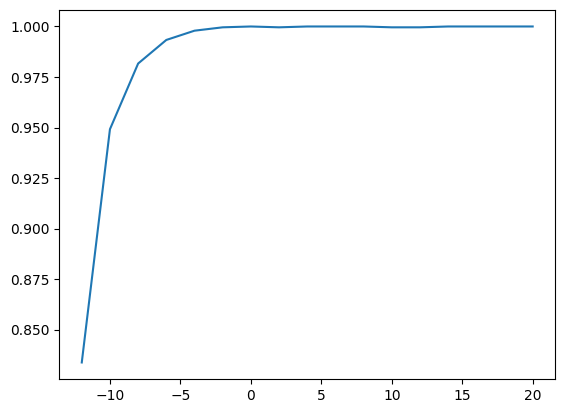

In [17]:
plt.plot(snrs, acc_val)

In [12]:
for k,val in signal_class.items():
    signal_class[k] = list([v*100for v in val])
    

In [29]:
y_true = [2, 0, 2, 2, 0, 3, 3]
y_pred = [0, 0, 2, 2, 0, 2, 3]
confusion_matrix(y_true, y_pred)


array([[2, 0, 0],
       [1, 2, 0],
       [0, 1, 1]])

In [13]:
type(signal_class)

dict

In [14]:
with open("/home/maria/8_signals/Results_attention/corr" + '/signal_acc.json', "w") as f:
    json.dump(signal_class, f)

In [16]:
import numpy

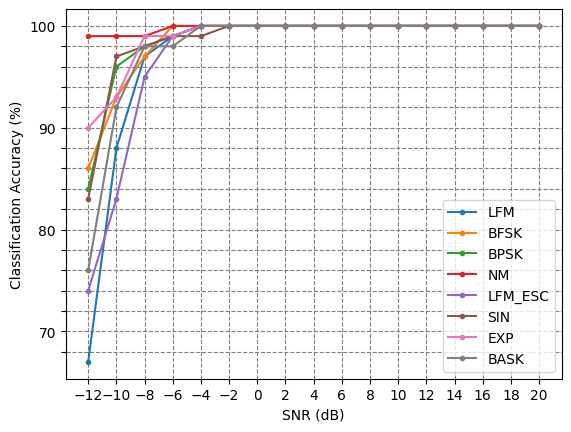

In [19]:
plt.figure()
ticks = []
a = numpy.arange(68, 102, 2)
for i in a:
    if i % 5 == 0:
        ticks.append(str(i))
    else:
        ticks.append("")
for i in range(len(classes)):
    plt.plot(snrs, signal_class[classes[i]], marker='.')
plt.legend(classes)
plt.yticks(a,ticks)
plt.xticks(snrs)
plt.grid(color = "grey", linewidth = "0.8", linestyle = "--")
plt.xlabel("SNR (dB)")
plt.ylabel("Classification Accuracy (%)")
plt.savefig(output_path+ '/graphs/signal_accuracy.png')
